In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error,accuracy_score
from sklearn.model_selection import train_test_split
import plotly.graph_objects as go
import plotly
import plotly.figure_factory as ff

In [2]:
df1 = pd.read_csv('./03July.csv')
df2 = pd.read_csv('./17July.csv')
# df1[df1['new_rate'].isnull()]
df1 = df1.dropna().reset_index(drop=True)
df2 = df2.dropna().reset_index(drop=True)

df1['day'] = 1
df2['day'] = 2
df1_columns=set(df1.columns)
df2_columns=set(df2.columns)
common_columns = list(df1_columns.intersection(df2_columns))

<h3> # df will be the merged dataset</h3>

In [3]:
df = pd.concat([df1[common_columns],df2[common_columns]])

In [4]:
def merge_rating(x):
    if x==1:
        return 1
    elif x in [1.5,2]:
        return 2
    elif x in [2.5,3]:
        return 3
    else:
        return 4

df['merged_rating'] = df.rate.apply(merge_rating)

In [5]:
df['merged_rating'].value_counts()

2    154
3     92
1     58
4     16
Name: merged_rating, dtype: int64

In [6]:
def create_features(df):
    X = df[['Correct_DGCI_l',' std_DGCI','c1', 'c2', 'c3', 'c4', 'c5','canopy','day']].copy()
    y = df.merged_rating.apply(lambda x: str(x)).copy()
    X_linear = X.apply(lambda x : np.round(x*100/x.canopy,2),1)
    X_linear[['canopy','Correct_DGCI_l', ' std_DGCI','day']] = X[['canopy','Correct_DGCI_l', ' std_DGCI','day']].copy()
    maxCanopy = max(X.canopy)
    X_linear.canopy = X_linear.canopy.apply(lambda x: np.round(x*100/maxCanopy,2))
    y= y.apply(lambda x: float(x))
    return (X_linear, y)
X_linear, y = create_features(df)

In [7]:
from imblearn.over_sampling import SMOTE, ADASYN
sm = SMOTE(random_state=2,k_neighbors=6)
X_resampled, y_resampled = sm.fit_sample(X_linear, df['merged_rating'])
X_resampled = pd.DataFrame(X_resampled)
X_resampled.columns = X_linear.columns

In [8]:
y_resampled = pd.Series(y_resampled)
X_resampled.shape

(616, 9)

In [9]:
DT = DecisionTreeClassifier(max_depth=6, min_samples_leaf=4)
Ada = AdaBoostClassifier(n_estimators=30,base_estimator=DT,random_state=42,learning_rate=0.01)

# try:
#     X_resampled.drop([' std_DGCI', 'c1', 'c2','c3','c4','c5'],inplace=True,axis=1)
# except:
#     print("")

# 10% percent is used for validation
from sklearn.model_selection import cross_val_score
X_train_resampled,X_valid_resampled , y_train_resampled,y_valid_resampled = train_test_split(
                                X_resampled, y_resampled, test_size = 0.2, random_state = 42, stratify=y_resampled)
scores = cross_val_score(Ada,X_train_resampled, y_train_resampled,cv=5,scoring = 'recall_macro')
np.mean(scores)

Ada.fit(X_train_resampled, y_train_resampled)
y_pred = Ada.predict(X_valid_resampled)
print(confusion_matrix(y_valid_resampled,y_pred))
print("****************** Train Results********************")
print(confusion_matrix(y_train_resampled,Ada.predict(X_train_resampled)))
print(y_train_resampled.value_counts())

[[21  4  5  1]
 [ 4 17 10  0]
 [ 2  7 20  2]
 [ 0  1  4 26]]
****************** Train Results********************
[[121   2   0   0]
 [  8 111   4   0]
 [  0   3 119   1]
 [  0   0   0 123]]
4    123
3    123
2    123
1    123
dtype: int64


In [10]:
print(classification_report(y_valid_resampled, y_pred))
print("*********** Accuracy score is {:.2} **************".format(accuracy_score(y_valid_resampled, y_pred)))

              precision    recall  f1-score   support

           1       0.78      0.68      0.72        31
           2       0.59      0.55      0.57        31
           3       0.51      0.65      0.57        31
           4       0.90      0.84      0.87        31

    accuracy                           0.68       124
   macro avg       0.69      0.68      0.68       124
weighted avg       0.69      0.68      0.68       124

*********** Accuracy score is 0.68 **************


In [11]:
print(confusion_matrix(y_valid_resampled,Ada.predict(X_valid_resampled)))
print(y_valid_resampled.value_counts())
print(classification_report(y_valid_resampled, Ada.predict(X_valid_resampled)))

[[21  4  5  1]
 [ 4 17 10  0]
 [ 2  7 20  2]
 [ 0  1  4 26]]
4    31
3    31
2    31
1    31
dtype: int64
              precision    recall  f1-score   support

           1       0.78      0.68      0.72        31
           2       0.59      0.55      0.57        31
           3       0.51      0.65      0.57        31
           4       0.90      0.84      0.87        31

    accuracy                           0.68       124
   macro avg       0.69      0.68      0.68       124
weighted avg       0.69      0.68      0.68       124



In [12]:
Ada.feature_importances_

array([0.087283  , 0.13093505, 0.10497573, 0.08729963, 0.11709022,
       0.09855852, 0.07301506, 0.20200803, 0.09883474])

In [13]:
X_linear.columns

Index(['Correct_DGCI_l', ' std_DGCI', 'c1', 'c2', 'c3', 'c4', 'c5', 'canopy',
       'day'],
      dtype='object')

<h2> Using cross validation for Adaboost model</h2>

<h2> Fitting Random Forest model</h2> 

In [14]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(n_estimators=100, random_state=42, min_samples_leaf=5, max_features=0.8, max_depth=6)

In [15]:
rf.fit(X_train_resampled, y_train_resampled)
y_pred = rf.predict(X_valid_resampled)
print(confusion_matrix(y_valid_resampled,y_pred))
print("****************** Train Results********************")
print(confusion_matrix(y_train_resampled,rf.predict(X_train_resampled)))
print(y_train_resampled.value_counts())

[[18  3  8  2]
 [ 6 14  9  2]
 [ 2  9 17  3]
 [ 0  1  1 29]]
****************** Train Results********************
[[106   7   8   2]
 [ 15  84  17   7]
 [  4  13  93  13]
 [  0   0   0 123]]
4    123
3    123
2    123
1    123
dtype: int64


In [16]:
print(classification_report(y_valid_resampled, y_pred))
print("*********** Accuracy score is {:.2} **************".format(accuracy_score(y_valid_resampled, y_pred)))

              precision    recall  f1-score   support

           1       0.69      0.58      0.63        31
           2       0.52      0.45      0.48        31
           3       0.49      0.55      0.52        31
           4       0.81      0.94      0.87        31

    accuracy                           0.63       124
   macro avg       0.63      0.63      0.62       124
weighted avg       0.63      0.63      0.62       124

*********** Accuracy score is 0.63 **************


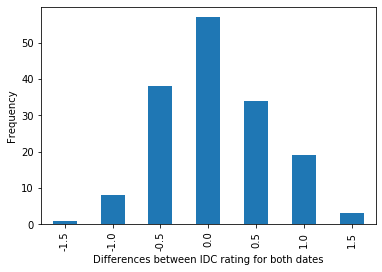

In [17]:
Diff = df1[['Plot Number','rate','Correct_DGCI_l']]
Diff = pd.merge(Diff, df2[['Plot Number','rate','Correct_DGCI_l']], on='Plot Number',suffixes=('_1','_2'))
Diff['diff_rate'] = Diff.rate_2 - Diff.rate_1
Diff['diff_dgci'] = Diff.Correct_DGCI_l_2 - Diff.Correct_DGCI_l_1
Diff.diff_dgci.hist()
plt.xlabel('Differences between average DGCI for both dates')
plt.ylabel('Frequency')
plt.savefig(r'C:\Users\oveis.jalilian\Desktop\{}.pdf'.format("DGCI_diff"),dpi=600,bbox_inches='tight')
plt.clf()
Diff.diff_rate.value_counts().sort_index().plot(kind='bar')
plt.xlabel('Differences between IDC rating for both dates')
plt.ylabel('Frequency')
plt.savefig(r'C:\Users\oveis.jalilian\Desktop\{}.pdf'.format("rate_diff"),dpi=600,bbox_inches='tight')
# Diff.diff_rate.value_counts().sort_index()*100/len(Diff)

In [18]:
Summary = X_linear[X_linear.day==2].describe()
Summary.round(2)

Correct_DGCI_l   std_DGCI      c1      c2      c3      c4      c5  \
count          160.00     160.00  160.00  160.00  160.00  160.00  160.00   
mean             0.29       0.11   20.93   62.64   15.08    1.28    0.07   
std              0.03       0.02    9.00    7.97    7.16    1.91    0.27   
min              0.22       0.07    4.21   41.31    3.63    0.01    0.00   
25%              0.27       0.09   14.38   56.91    9.79    0.26    0.00   
50%              0.29       0.10   19.96   63.36   13.98    0.60    0.00   
75%              0.31       0.12   27.07   69.23   19.49    1.22    0.00   
max              0.41       0.18   44.56   79.06   39.01   10.06    2.03   

       canopy    day  
count  160.00  160.0  
mean    52.12    2.0  
std     14.99    0.0  
min      9.26    2.0  
25%     41.65    2.0  
50%     52.10    2.0  
75%     61.63    2.0  
max    100.00    2.0

In [19]:
x = sorted(Diff.diff_rate.unique())
y = Diff.diff_rate.value_counts().sort_index()
y = [i for i in y]

colors = ['#E09C00','#FFD700','#DDE800','#BBD900','#97FF00','#5BCF00','#449A00']

fig = go.Figure(data=[go.Bar(
            x=x, y=y,
            text=y,
            marker_color=colors
        )])


fig.update_layout(
    template="plotly_white",
    autosize=True,
    width=700,
    height=500,
    yaxis=dict(
        title='Frequency'
    ),
    xaxis=dict(
        title='Differences between IDC rating for both dates'
    ),
    xaxis_showgrid=False, yaxis_showgrid=False

)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)

fig.show()

In [20]:
colors= ['#c5d627','#b3d627','#9fd627','#90d627',
         '#7fd627','#6ad627','#56d627','#47d627',
         '#43bd28','#3fab27','#3b9c25','#388c24']
fig = go.Figure(data=[go.Histogram(x=Diff.diff_dgci,marker_color=colors)])
fig.update_layout(
    template="plotly_white",
    autosize=True,
    width=600,
    height=500,
    yaxis=dict(
        title='Frequency'
    ),
    xaxis=dict(
        title='Differences between average DGCI of both dates'
    ),

                  xaxis_showgrid=False, yaxis_showgrid=False)
    
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)

fig.show()

In [21]:
test = df[['Correct_DGCI_l','day','rate']].copy()
test[test.day==2].describe()

Correct_DGCI_l    day        rate
count      160.000000  160.0  160.000000
mean         0.292636    2.0    2.056250
std          0.034723    0.0    0.852277
min          0.224285    2.0    1.000000
25%          0.267994    2.0    1.000000
50%          0.291239    2.0    2.000000
75%          0.314541    2.0    3.000000
max          0.405788    2.0    4.000000

In [64]:
x3_1=df.loc[(df['day']==1)&(df['merged_rating']==3),'Correct_DGCI_l']
x2_1=df.loc[(df['day']==1)&(df['merged_rating']==2),'Correct_DGCI_l']
x1_1=df.loc[(df['day']==1)&(df['merged_rating']==1),'Correct_DGCI_l']
hist_data = [x3_1, x2_1, x1_1]

group_labels = ['MR=3','MR=2','MR=1']
colors = ['#DDE800','#BBD900','#449A00']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels,bin_size=0.1, show_hist=False, colors=colors,show_rug=False,show_curve=True)

# Add title

# fig.update_traces(line=dict(width=3.5))

fig.update_layout(title_text='',width=700, height=450,
                  template="plotly_white",
                  yaxis=dict(title='Frequency'),
                  xaxis=dict(title='DGCI',tickmode = 'linear',tick0 = 0.00,dtick = 0.01),
                  xaxis_showgrid=False, yaxis_showgrid=False,showlegend=True)

fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)



fig.show()

In [59]:
import plotly.graph_objects as go

fig = go.Figure()
fig.add_trace(go.Histogram(x=x1_1, name='MR=1', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#449A00',
    opacity=0.75))
fig.add_trace(go.Histogram(x=x2_1, name='MR=2', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#BBD900',
    opacity=0.75))
fig.add_trace(go.Histogram(x=x3_1, name='MR=3', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#E09C00',
    opacity=0.75))

fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_layout(title_text='',width=650, height=425,
                  template="plotly_white",
                  yaxis=dict(title='Frequency'),
                  xaxis=dict(title='DGCI',tickmode = 'linear',tick0 = 0.00,dtick = 0.02),
                  xaxis_showgrid=False, yaxis_showgrid=False,showlegend=True)
fig.update_layout(
    legend=dict(x=0.8,y=0.95, traceorder="normal",
        font=dict(
            family="sans-serif",
            size=10,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=1
    )
)


In [24]:
import seaborn as sns

In [25]:
X=x1_1.values.copy()
X.shape

(17,)

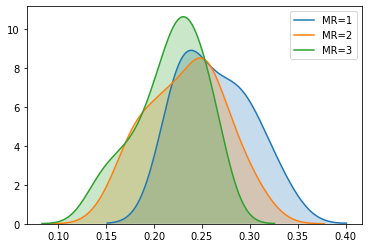

In [62]:
sns.kdeplot(x1_1,shade=True, label="MR=1")
sns.kdeplot(x2_1,shade=True, label="MR=2")
sns.kdeplot(x3_1,shade=True, label="MR=3")

plt.savefig('test.pdf')

In [28]:
x4=df.loc[(df['day']==2)&(df['merged_rating']==4),'Correct_DGCI_l']
x3=df.loc[(df['day']==2)&(df['merged_rating']==3),'Correct_DGCI_l']
x2=df.loc[(df['day']==2)&(df['merged_rating']==2),'Correct_DGCI_l']
x1=df.loc[(df['day']==2)&(df['merged_rating']==1),'Correct_DGCI_l']
hist_data = [x4, x3, x2, x1]

group_labels = ['MR=4','MR=3','MR=2','MR=1']
colors = ['#E09C00','#DDE800','#BBD900','#449A00']

# Create distplot with curve_type set to 'normal'
fig = ff.create_distplot(hist_data, group_labels, show_hist=False, colors=colors,show_rug=False)

# Add title
fig.update_layout(title_text='',width=700, height=450,
                  template="plotly_white",
                  yaxis=dict(title='Frequency'),
                  xaxis=dict(title='DGCI',tickmode = 'linear',tick0 = 0.00,dtick = 0.02),
                  xaxis_showgrid=False, yaxis_showgrid=False)
fig.update_traces(line=dict(width=3.5))
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.show()

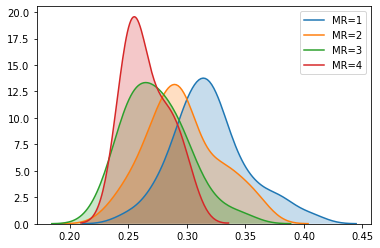

In [29]:
sns.kdeplot(x1,shade=True, label="MR=1")
sns.kdeplot(x2,shade=True, label="MR=2")
sns.kdeplot(x3,shade=True, label="MR=3")
sns.kdeplot(x4,shade=True, label="MR=4")
plt.savefig('test2.pdf')

In [61]:
fig = go.Figure()
fig.add_trace(go.Histogram(x=x1, name='MR=1', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#449A00',
    opacity=0.75))
fig.add_trace(go.Histogram(x=x2, name='MR=2', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#BBD900',
    opacity=0.75))
fig.add_trace(go.Histogram(x=x3, name='MR=3', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#ffF000',
    opacity=0.75))
fig.add_trace(go.Histogram(x=x4, name='MR=4', xbins=dict(start=0,end=.4,size=0.02),
    marker_color='#E09C00',
    opacity=0.75))

fig.update_xaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_yaxes(showline=True, linewidth=1, linecolor='black',ticks='outside',mirror=True)
fig.update_layout(title_text='',width=650, height=425,
                  template="plotly_white",
                  yaxis=dict(title='Frequency'),
                  xaxis=dict(title='DGCI',tickmode = 'linear',tick0 = 0.00,dtick = 0.02),
                  xaxis_showgrid=False, yaxis_showgrid=False,showlegend=True)

fig.update_layout(
    legend=dict(x=0.8,y=0.95, traceorder="normal",
        font=dict(
            family="sans-serif",
            size=10,
            color="black"
        ),
        bordercolor="Black",
        borderwidth=1
    )
)